In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
from model.MLP_encoder import MLPEncoder, StateEncoderRegion
from model.MLP_encoder_ACD import MLPEncoder as MLPEncoder_ACD
from model.MLP_decoder_ACD import MLPDecoder as MLPDecoder_ACD
from model.MLP_decoder import ReducedMLPDecoder, MLPDecoder, MLPDecoderDynam
from model.NRIMPMEncoders import AttENC, RNNENC
from model.StateDecoder import StateDecoder
from model.StateGRNNEncoder import StateGRNNEncoderSmall
from datasets.data_loaders import LinearDataLoader, load_springs_data
from torch.utils.data import DataLoader
import torch
from model.utils import *
from datasets.data_loaders import LinearDataLoader, load_springs_data, NBADataset
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from itertools import permutations


## Load Data

In [3]:
train_dataset = NBADataset('/data2/users/cb221/NBA-Player-Movements/NBA_dataset/', '/data2/users/cb221/NBA-Player-Movements/NBA_dataset/indices_test.npy')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
num_atoms = 10
num_dims = 4
seq_len = 100
state_dim = 2
num_states = 2
device = 'cuda:0'
rel_rec, rel_send = create_rel_rec_send(num_atoms)
rel_rec, rel_send = rel_rec.to(device), rel_send.to(device)
es = torch.LongTensor(np.array(list(permutations(range(num_atoms), 2))).T).to(device)

In [4]:
sample_list = [sample for sample in train_loader]
print(len(sample_list))

89


## Graph exploration

In [5]:
num_dims = 4
num_states = 4
path = '/data2/users/cb221/video_causal_discovery/models_ICML_NBA/SDCI_4_states_region_sparsity_0.8_latest.pth.tar'
encoder = MLPEncoder(num_dims*seq_len, 256, 2, num_states).float().cuda()
state_encoder = StateEncoderRegion(num_dims, 256, num_states).float().cuda()
decoder = MLPDecoder(num_dims, num_states, 2, 256, 256, 256, False,
        ball_cond=True).float().cuda()
checkpoint = torch.load(path)
encoder.load_state_dict(checkpoint['state_dict_encoder'])
state_encoder.load_state_dict(checkpoint['state_dict_state_encoder'])
decoder.load_state_dict(checkpoint['state_dict_decoder'])
encoder.eval()
state_encoder.eval()
decoder.eval()

Using factor graph MLP encoder.
Using learned interaction net decoder.


MLPDecoder(
  (msg_fc1): ModuleList(
    (0-1): 2 x Linear(in_features=8, out_features=256, bias=True)
  )
  (msg_fc2): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
  )
  (out_fc1): Linear(in_features=266, out_features=256, bias=True)
  (out_fc2): Linear(in_features=256, out_features=256, bias=True)
  (out_fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [6]:
edge_list = np.empty((0,4))
for sample in sample_list:
    data = sample
    data = data.float().cuda()
    sequence = data[:,:100,:-1,:][:,:,:,[0,1,3,4]].transpose(1,2)
    edge_probs = encoder(sequence, rel_rec, rel_send)
    
    edges = gumbel_softmax(edge_probs, tau=0.5, hard=True)
    state_probs = state_encoder(sequence)
    state_probs = simple(edge_probs, tau=0.5)
    edge_list = np.concatenate((edge_list,edges.max(-1)[-1].float().sum(1).cpu()),axis=0)

In [66]:
import networkx as nx
def create_graph(edge_set, state_idx=0, num_atoms=5):
    G = nx.DiGraph()
    nodes = list(range(num_atoms+1))
    G.add_nodes_from(nodes[1:5+1], bipartite = 0)
    G.add_nodes_from(nodes[5+1:], bipartite = 1)
    counter = 0
    for i in range(num_atoms):
        for j in range(num_atoms):
            if i != j:
                if edge_set[counter][state_idx] != 0:
                    G.add_edge(j+1,i+1, len=1)
                counter += 1
    edges = G.edges
    
    return G

In [8]:
data = next(iter(train_loader))
data = data.float().cpu()
#
n = np.random.randint(data.shape[0])
data_viz = data.clone()
data_viz[:,:,:,1]/=2
print(n)

11


In [9]:
np.save('data_sample_NBA.npy', data.cpu().numpy())

12


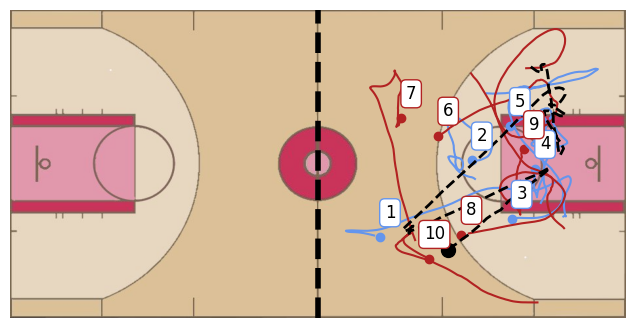

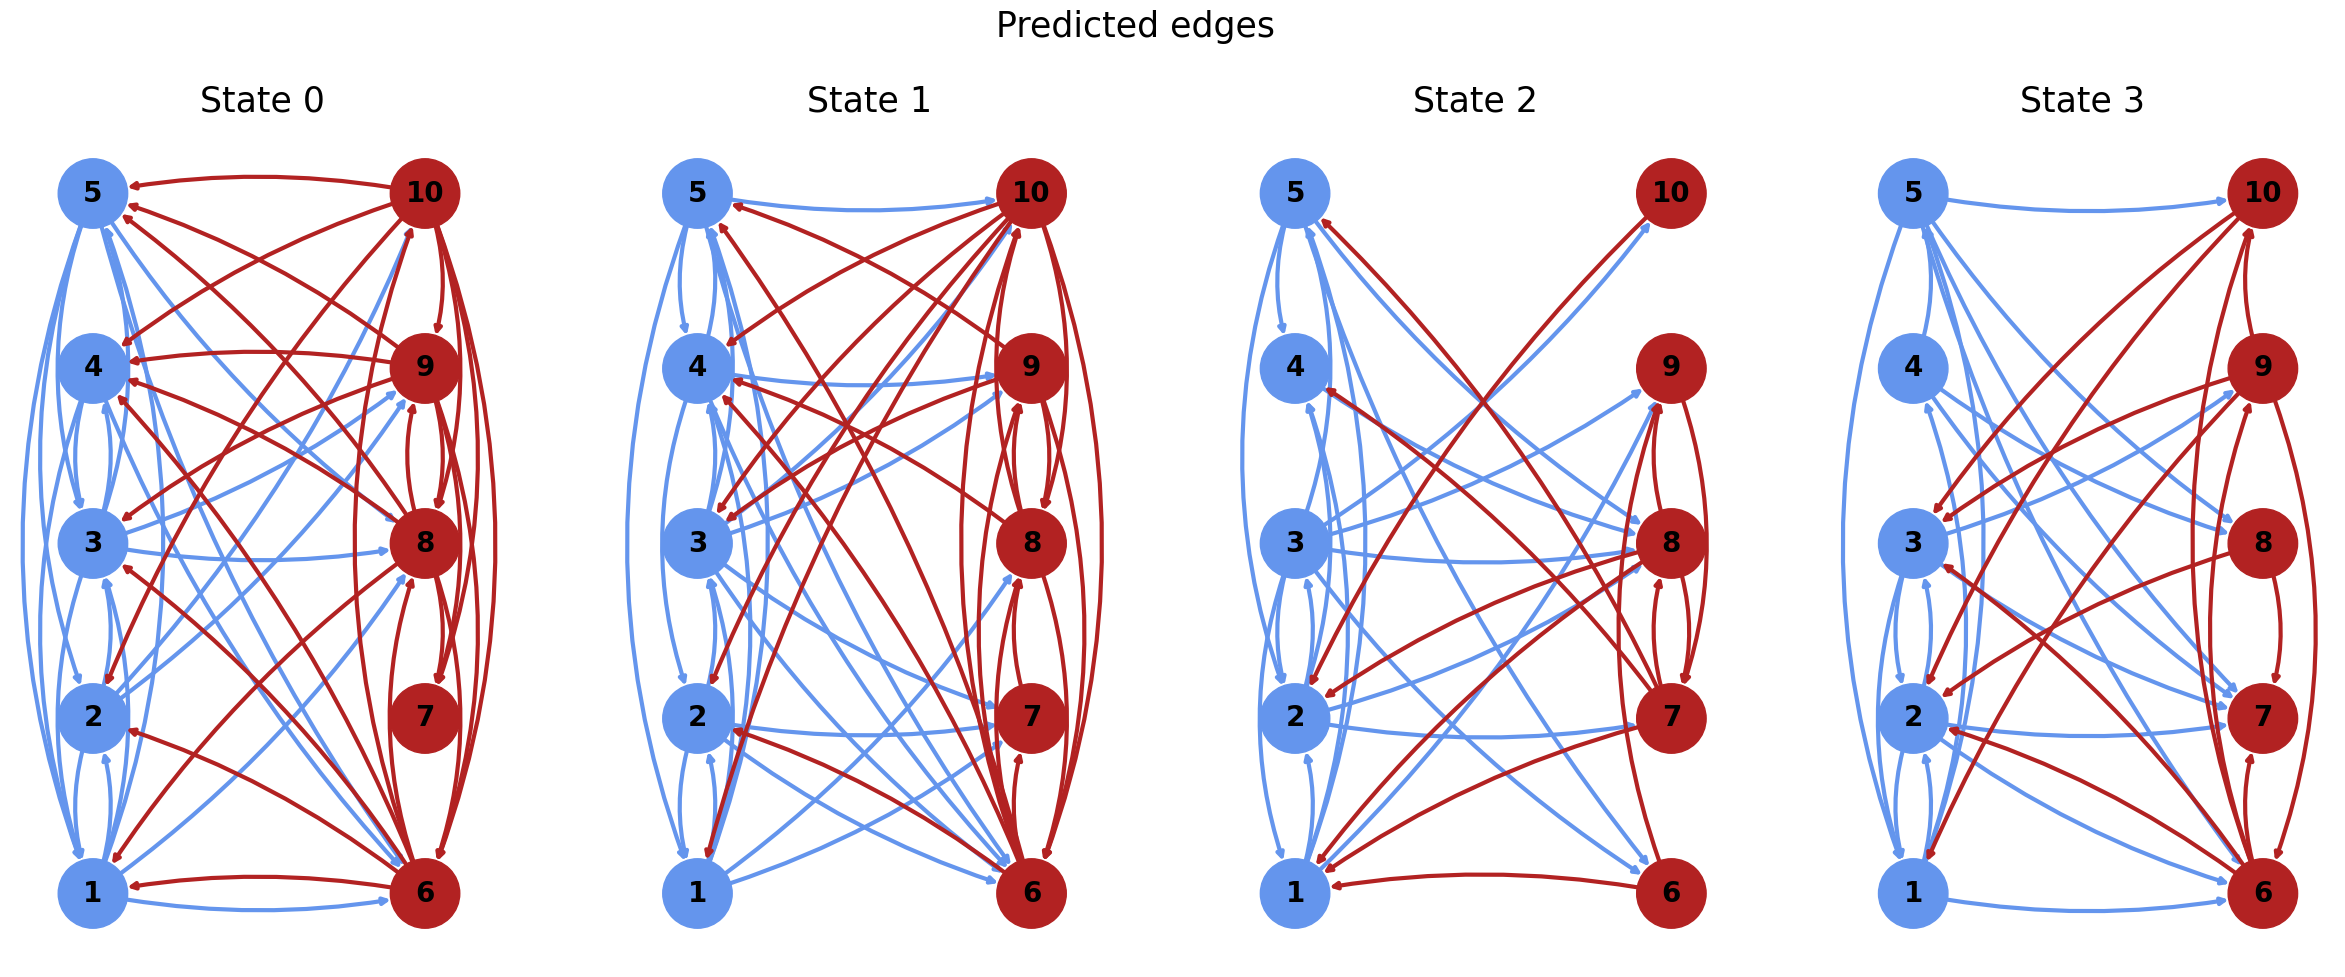

In [21]:
data = next(iter(train_loader))
data = data.float().cpu()
#
n = np.random.randint(data.shape[0])
data_viz = data.clone()
data_viz[:,:,:,1]/=2
print(n)

fig = plt.figure(figsize=(8,4))
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth=4)
for i in range(5):
    plt.plot(data_viz[n][:100,i,0],data_viz[n][:100,i,1], color='cornflowerblue')
    plt.scatter(data_viz[n][100,i,0],data_viz[n][100,i,1], color='cornflowerblue')
    plt.text(
        data_viz[n][100,i,0]+0.05, data_viz[n][100,i,1]-0.05, str(i+1), fontsize=12,
        ha="right", va="bottom", color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="cornflowerblue", facecolor="white")
    )
for i in range(5):
    plt.plot(data_viz[n][:100,i+5,0],data_viz[n][:100,i+5,1], color='firebrick')
    plt.scatter(data_viz[n][100,i+5,0],data_viz[n][100,i+5,1], color='firebrick')
    plt.text(
        data_viz[n][100,i+5,0]+0.05, data_viz[n][100,i+5,1]-0.05, str(i+6), fontsize=12,
        ha="right", va="bottom", color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="firebrick", facecolor="white")
    )
plt.plot(data_viz[n][:100,-1,0],data_viz[n][:100,-1,1],color='black', linestyle='--', linewidth=2)
plt.scatter(data_viz[n][100,-1,0],data_viz[n][100,-1,1],color='black', s=100)
plt.xlim(-1,1)
court = plt.imread("/data2/users/cb221/NBA-Player-Movements/court.png")
plt.imshow(court, zorder=0, extent=[-1, 1, 0.5, -0.5])
plt.axis('off')
plt.savefig("NBA_play_example_3.pdf", bbox_inches='tight')
plt.show()
data = data.float().cuda()
sequence = data[:,:100,:-1,:][:,:,:,[0,1,3,4]].transpose(1,2)
edge_probs = encoder(sequence, rel_rec, rel_send)

edges = gumbel_softmax(edge_probs, tau=0.5, hard=True)
state_probs = state_encoder(sequence)
state_samp = simple(state_probs, tau=0.5)

#B=1
top_nodes = list(range(1,5+1))
bottom_nodes = list(range(5+1,10+1))
def edge_curvature(u, v):
    if u in top_nodes and v in top_nodes:  # Intra-set in top group
        return 0.2
    elif u in bottom_nodes and v in bottom_nodes:  # Intra-set in bottom group
        return -0.2
    else:  # Inter-group edges
        return 0.1  # Straight edges

def get_edge_color(u, v):
    if u in top_nodes:  # Both nodes are in top set
        return "blue"
    elif u in bottom_nodes:  # Both nodes are in bottom set
        return "red"
    return 'black'

G = [create_graph(edges[n].max(-1)[-1], state_id, 10) for state_id in range(num_states)]

plt.figure(figsize=(30,11))
for i, g in enumerate(G, 0):
    ax = plt.subplot(1,num_states,i+1)
    plt.title('State ' + str(i), fontsize=25)
    
    edge_colors = []
    for u, v in g.edges:
        if u in top_nodes:
            edge_colors.append("cornflowerblue")  # Edges originating from 'top_nodes'
        else:
            edge_colors.append("firebrick")   # Edges originating from 'bottom_nodes'
    top_set = {v for v, d in g.nodes(data=True) if d['bipartite'] == 0}
    bottom_set = {v for v, d in g.nodes(data=True) if d['bipartite'] == 1}
    # Positioning for bipartite graph layout
    pos = nx.drawing.layout.bipartite_layout(g, top_nodes)
    nx.draw(
        g, pos, with_labels=True, 
        node_color=["cornflowerblue" if v in top_set else "firebrick" for v in g.nodes()],
        node_size=2500, edge_color='white',width=0, font_size=20, font_weight="bold"
    )
    curved_edges = [(u, v, edge_curvature(u, v)) for u, v in g.edges]
    for u, v, rad in curved_edges:
        edge_color = edge_colors.pop(0)
        nx.draw_networkx_edges(
            g, pos, node_size=2500, edgelist=[(u, v)], ax=ax,
            connectionstyle=f"arc3,rad={rad}", edge_color=edge_color, width=3
        )
plt.suptitle('Predicted edges', fontsize=25)
plt.savefig("NBA_graph_example_3.pdf", bbox_inches='tight')
plt.show()

In [89]:
print(edges[n].max(-1)[-1].float().sum(0))

tensor([39., 38., 20., 32.], device='cuda:0')


[]

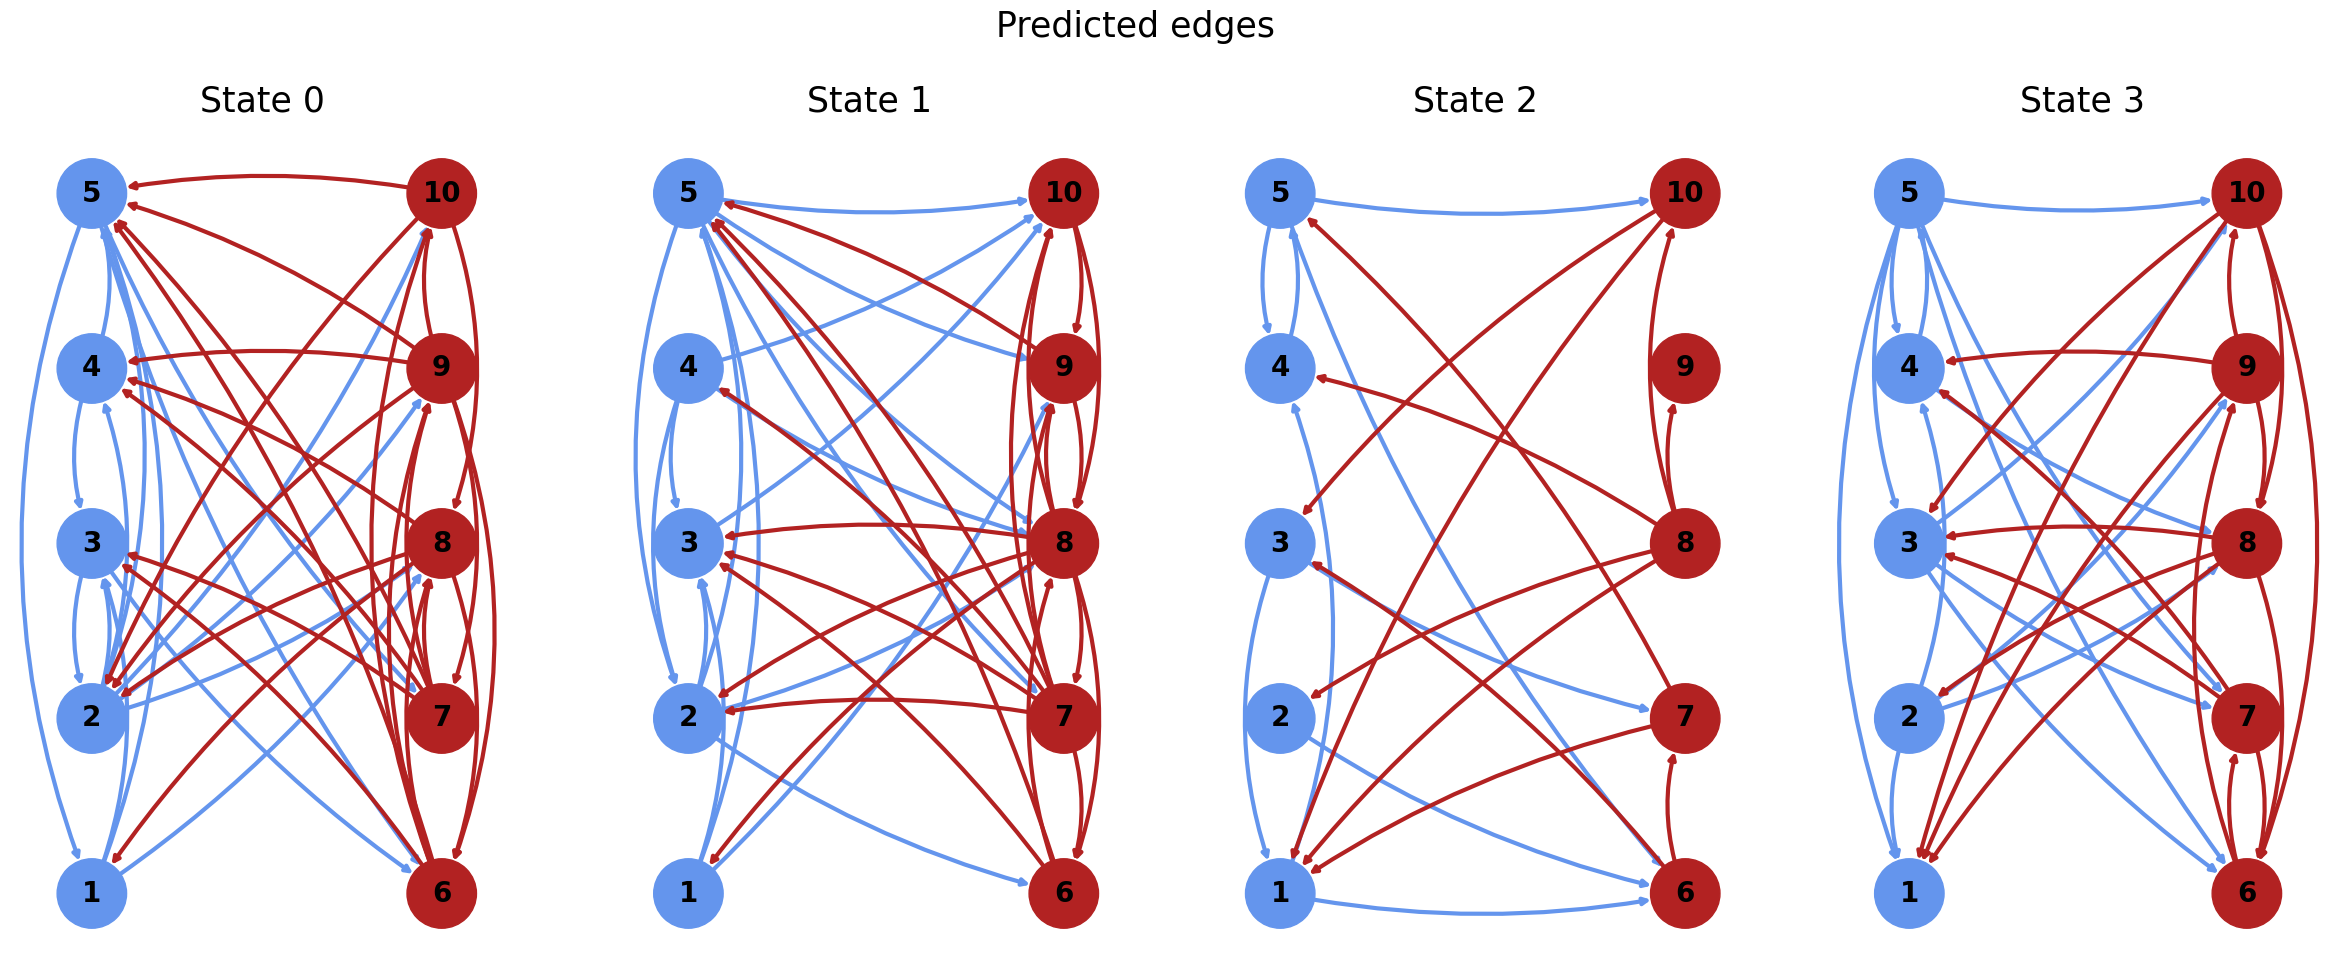

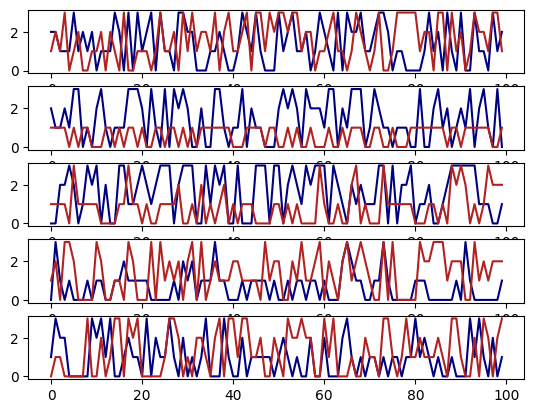

In [73]:
for i in range(5):
    plt.subplot(5,1,((i)%5)+1)
    plt.plot(range(100), state_samp[n,i].argmax(-1).detach().cpu(), color='navy')

for i in range(5,10):
    plt.subplot(5,1,((i)%5)+1)
    plt.plot(range(100), state_samp[n,i].argmax(-1).detach().cpu(), color='firebrick')

## State Visualisation

(100, 100)
torch.Size([100, 100, 2])


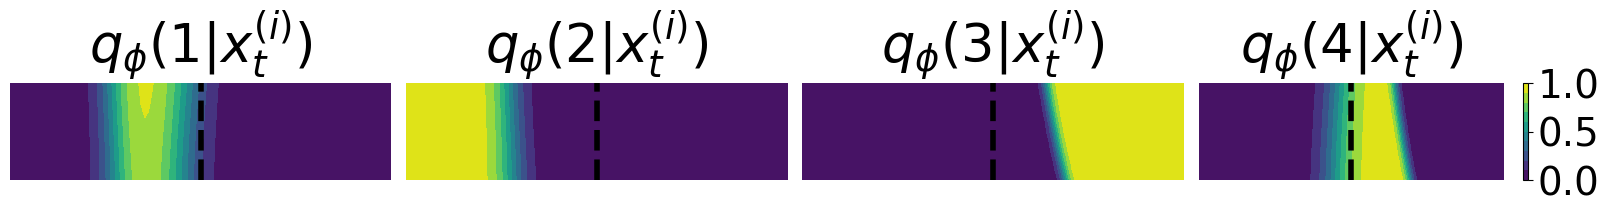

(100, 100)
torch.Size([100, 100, 2])


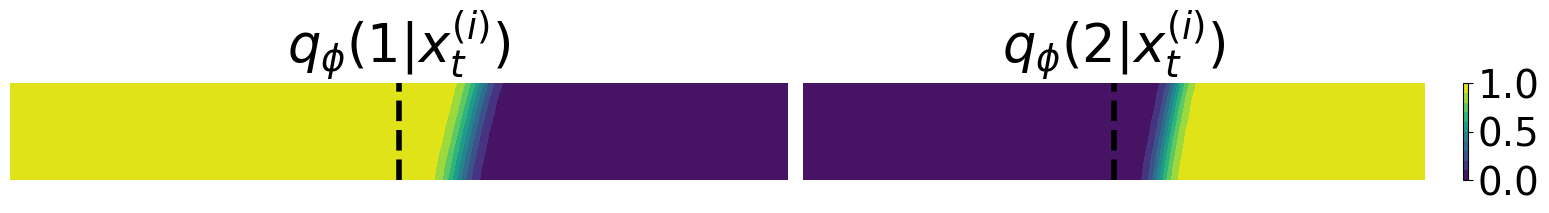

In [ ]:
from model.MLP_encoder import StateEncoderRegionOld as StateEncoderRegion
num_dims = 4
paths = [
    '/data2/users/cb221/video_causal_discovery/models/SDCI_4_state_new_hidden_only_pos_latest.pth.tar',
    '/data2/users/cb221/video_causal_discovery/models/SDCI_2_state_new_hidden_only_pos_latest.pth.tar'
]
for j, num_states, path_i in zip([1,2], [4, 2], paths):
    state_encoder = StateEncoderRegion(num_dims-2, 256, num_states).float().cuda()
    checkpoint = torch.load(path_i)
    state_encoder.load_state_dict(checkpoint['state_dict_state_encoder'])

    N = 100
    xlist = np.linspace(-1.0, 1.0, N)
    ylist = np.linspace(-1.0, 1.0, N)
    X, Y = np.meshgrid(xlist, ylist)
    print(X.shape)
    X_t = torch.from_numpy(X).unsqueeze(-1)
    Y_t = torch.from_numpy(Y).unsqueeze(-1)
    dom = torch.cat([X_t,Y_t], dim=-1).float().cuda()
    print(dom.size())
    #out, (h, c) = kvae.cpu().parameter_net(dom.reshape(-1, 2))
    #Z = kvae.cpu().alpha_out(out)
    Z = state_encoder(dom.reshape(-1,2))
    Z = (Z/0.5).softmax(-1).reshape(N,N,-1).detach().cpu().numpy()
    fig = plt.figure(figsize=(16,2))
    for i in range(num_states):
        ax = plt.subplot(1,num_states,i+1)
        plt.axis('off')
        plt.tight_layout()
        plt.title('$q_{\phi}($' + str(i+1) + '$|x^{(i)}_t)$', fontsize=38)
        plt.axvline(x = 1, color = 'k', linestyle = '--', linewidth=4)
        cp = ax.contourf(X, Y, Z[:,:,i], 10)
    cbar = plt.colorbar(cp, ticks=[0.0, 0.5, 1.0])
    cbar.ax.tick_params(labelsize=28)
    plt.savefig('NBA_states_' + str(num_states) + '_viz.pdf') 
    plt.show()

(200, 200)
torch.Size([200, 200, 2])


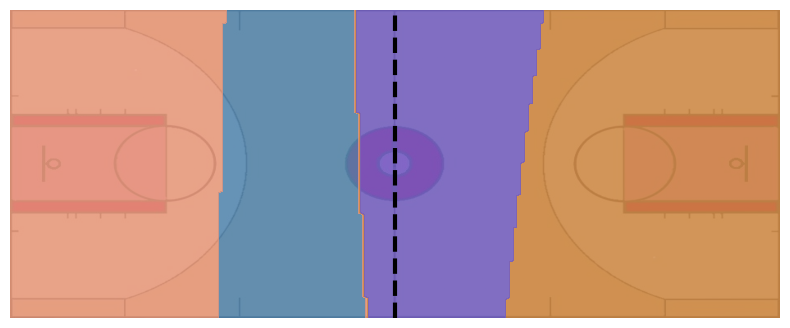

(200, 200)
torch.Size([200, 200, 2])


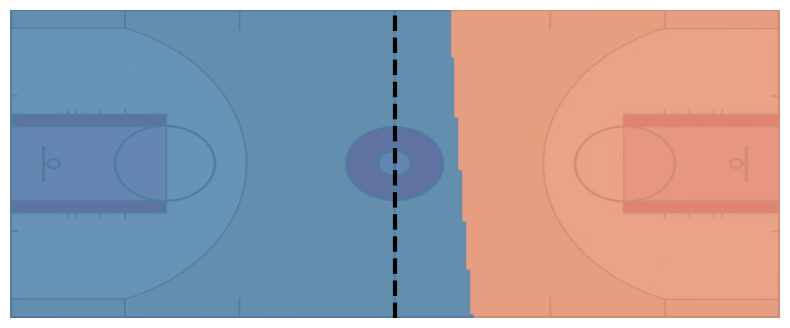

In [54]:
from model.MLP_encoder import StateEncoderRegionOld as StateEncoderRegion
from matplotlib.colors import ListedColormap, BoundaryNorm
num_dims = 4
paths = [
    '/data2/users/cb221/video_causal_discovery/models/SDCI_4_state_new_hidden_only_pos_latest.pth.tar',
    '/data2/users/cb221/video_causal_discovery/models/SDCI_2_state_new_hidden_only_pos_latest.pth.tar'
]
for j, num_states, path_i in zip([1,2], [4, 2], paths):
    state_encoder = StateEncoderRegion(num_dims-2, 256, num_states).float().cuda()
    checkpoint = torch.load(path_i)
    state_encoder.load_state_dict(checkpoint['state_dict_state_encoder'])

    N = 200
    xlist = np.linspace(-1.5, 3.5, N)
    ylist = np.linspace(-1.5, 0.5, N)
    X, Y = np.meshgrid(xlist, ylist)
    print(X.shape)
    X_t = torch.from_numpy(X).unsqueeze(-1)
    Y_t = torch.from_numpy(Y).unsqueeze(-1)
    dom = torch.cat([X_t,Y_t], dim=-1).float().cuda()
    print(dom.size())
    #out, (h, c) = kvae.cpu().parameter_net(dom.reshape(-1, 2))
    #Z = kvae.cpu().alpha_out(out)
    Z = state_encoder(dom.reshape(-1,2))
    
    Z = (Z/0.5).reshape(N,N,-1).argmax(-1).detach().cpu().numpy()+1
    levels = [0, 1, 2, 3, 4]  # Integer levels
    colors = ['steelblue', 'darksalmon', 'peru','slateblue']  # Custom colors for the levels
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, len(colors))
    fig = plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.tight_layout()
    plt.axvline(x = 1, color = 'k', linestyle = '--', linewidth=3)
    contour = plt.contourf(X, Y, Z, levels=levels, cmap=cmap, norm=norm, alpha=0.8)
    court = plt.imread("/data2/users/cb221/NBA-Player-Movements/court.png")
    plt.imshow(court, zorder=0, extent=[-1.5, 3.5, 0.5, -1.5])
    plt.savefig('NBA_states_' + str(num_states) + '_viz.pdf', bbox_inches='tight') 
    plt.show()

## Gene Regulatory Networks

In [22]:
import sys
sys.path.append("../..")
from model.EncoderFixed import EncoderFixed
from model.MLP_decoder import MLPDecoder
from model.MLP_encoder import StateEncoderRegion
from datasets.data_loaders import GRN
import torch
from sklearn.metrics import roc_auc_score, f1_score
from model.utils import my_softmax, create_rel_rec_send
from sklearn.metrics import classification_report
import numpy as np

def get_off_diag_idx(num_atoms):
    return np.ravel_multi_index(
        np.where(np.ones((num_atoms, num_atoms)) - np.eye(num_atoms)),
        [num_atoms, num_atoms],
    )

In [58]:
num_atoms = 49
num_edge_types = 2
num_states = 2
hidden_dim = 128
num_dims = 1

off_diag_idx = get_off_diag_idx(num_atoms)

# adj mat reads as follows [i,j] -> (target, source)
adj_mat = np.load("datasets/sdci_dyngen/gene_regulation_gt_1000.npy")
print(adj_mat.shape)
edges_true = adj_mat.reshape((num_atoms**2))[off_diag_idx]


off_diag_idx = get_off_diag_idx(num_atoms)
encoder = EncoderFixed(num_atoms, num_edge_types, num_states).float()
checkpoint = torch.load("models_ICML_GRN/GRN_region_1_0.8_embedding_cont_latest.pth.tar", map_location='cpu')
encoder.load_state_dict(checkpoint['state_dict_encoder'])

edge_probs = encoder().detach().cpu()
prob = my_softmax(edge_probs, -1)
pred_prob = prob[...,1].max(-1)[0].numpy()

print(roc_auc_score(edges_true.flatten(), pred_prob.flatten()))
print(f1_score(edges_true.flatten(), pred_prob.flatten() > 0.5))
print(classification_report(edges_true.flatten(), pred_prob.flatten() > 0.5))
print((edges_true.flatten() == (pred_prob.flatten() > 0.5)).mean())

(49, 49)
0.9358907681319215
0.3804347826086957
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      2289
         1.0       0.29      0.56      0.38        63

    accuracy                           0.95      2352
   macro avg       0.64      0.76      0.68      2352
weighted avg       0.97      0.95      0.96      2352

0.951530612244898


In [59]:
graph_infer = np.zeros((num_atoms**2,2))
graph_infer[off_diag_idx] = (prob[...,1] > 0.5).numpy()



In [60]:
def group_matrix(matrix):
    grouped_matrix = np.zeros((21,21))

    grouped_matrix[0,0] = matrix[:5,:5].max()
    grouped_matrix[0,1] = matrix[:5,5:9].max()
    grouped_matrix[0,2] = matrix[:5,9:23].max()
    grouped_matrix[0,3] = matrix[:5,23:29].max()
    grouped_matrix[0,4] = matrix[:5,29:33].max()
    grouped_matrix[0,5:] = matrix[:5,33:].max(0)

    grouped_matrix[1,0] = matrix[5:9,:5].max()
    grouped_matrix[1,1] = matrix[5:9,5:9].max()
    grouped_matrix[1,2] = matrix[5:9,9:23].max()
    grouped_matrix[1,3] = matrix[5:9,23:29].max()
    grouped_matrix[1,4] = matrix[5:9,29:33].max()
    grouped_matrix[1,5:] = matrix[5:9,33:].max(0)

    grouped_matrix[2,0] = matrix[9:23,:5].max()
    grouped_matrix[2,1] = matrix[9:23,5:9].max()
    grouped_matrix[2,2] = matrix[9:23,9:23].max()
    grouped_matrix[2,3] = matrix[9:23,23:29].max()
    grouped_matrix[2,4] = matrix[9:23,29:33].max()
    grouped_matrix[2,5:] = matrix[9:23,33:].max(0)

    grouped_matrix[3,0] = matrix[23:28,:5].max()
    grouped_matrix[3,1] = matrix[23:28,5:9].max()
    grouped_matrix[3,2] = matrix[23:28,9:23].max()
    grouped_matrix[3,3] = matrix[23:28,23:29].max()
    grouped_matrix[3,4] = matrix[23:28,29:33].max()
    grouped_matrix[3,5:] = matrix[23:28,33:].max(0)

    grouped_matrix[4,0] = matrix[29:33,:5].max()
    grouped_matrix[4,1] = matrix[29:33,5:9].max()
    grouped_matrix[4,2] = matrix[29:33,9:23].max()
    grouped_matrix[4,3] = matrix[29:33,23:29].max()
    grouped_matrix[4,4] = matrix[29:33,29:33].max()
    grouped_matrix[4,5:] = matrix[29:33,33:].max(0)

    grouped_matrix[5:,0] = matrix[33:,:5].max(-1)
    grouped_matrix[5:,1] = matrix[33:,5:9].max(-1)
    grouped_matrix[5:,2] = matrix[33:,9:23].max(-1)
    grouped_matrix[5:,3] = matrix[33:,23:29].max(-1)
    grouped_matrix[5:,4] = matrix[33:,29:33].max(-1)
    grouped_matrix[5:,5:] = matrix[33:,33:]

    return grouped_matrix

In [61]:
graph_infer.shape
state_1_matrix = group_matrix(graph_infer.reshape(num_atoms,num_atoms,2)[...,0])
state_2_matrix = group_matrix(graph_infer.reshape(num_atoms,num_atoms,2)[...,1])

In [ ]:
np.fill_diagonal(state_1_matrix,0)
np.fill_diagonal(state_2_matrix,0)
print(state_1_matrix.sum())
print(state_2_matrix.sum())

21.0
17.0


In [181]:
import networkx as nx
node_center =["A", "B", "C", "D"]
def create_graph(edge_set,num_atoms=5):
    G = nx.DiGraph()
    nodes = list(range(num_atoms+1))
    counter = 0
    for i in range(num_atoms):
        node_to = i+1
        if node_to <= 4:
            node_to = node_center[i]
        G.add_node(node_to)
    for i in range(num_atoms):
        for j in range(num_atoms):
            if i != j:
                if edge_set[counter] != 0 and j < 4:
                    node_from = j+1
                    node_to = i+1
                    if node_from <= 4:
                        node_from = node_center[j]
                    if node_to <= 4:
                        node_to = node_center[i]
                    G.add_edge(node_from,node_to, len=1)
                counter += 1
    edges = G.edges
    
    return G

In [166]:
print(state_1_matrix[1:6,1:6])

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


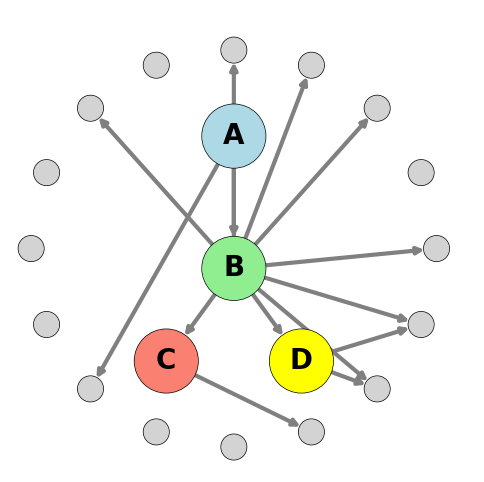

In [192]:
off_diag_idx = get_off_diag_idx(20)
g = create_graph(state_1_matrix[1:,1:].reshape(20**2)[off_diag_idx], 20)


node_center =["A", "B", "C", "D"]

for i, node in enumerate(node_center[:2]):
    pos[node] = (0, -i-0.65)
pos["C"] = (-0.5, -2-0.35)
pos["D"] = (0.5, -2-0.35)

# Arrange orbit nodes in a circular layout around the main ones
angle_step = 2 * np.pi / 16
radius = 1.5
for i, node in enumerate(range(5,21)):
    angle = i * angle_step
    pos[node] = (radius * np.cos(angle), -1.5 + radius * np.sin(angle))  # Centered around (0, -2)

node_sizes = {node: 2000 for node in node_center}  # Larger main nodes
node_sizes.update({node: 300 for node in range(5,21)})  # Smaller orbit nodes

node_colors = {"A": 'lightblue',
               "B": 'lightgreen',
               "C": 'salmon',
               "D": 'yellow'}  # Larger main nodes
node_colors.update({node: 'lightgray' for node in range(5,21)})  # Smaller orbit nodes

fontsizes = {node: 20 for node in node_center}  # Larger main nodes
fontsizes.update({node: 10 for node in range(5,21)})  # Smaller orbit nodes

plt.figure(figsize=(6, 6))

nx.draw_networkx_nodes(g, pos, node_size=[node_sizes[n] for n in g.nodes()], 
                       node_color='lightblue', edgecolors='black', linewidths=2)


nx.draw(g, pos, with_labels=False, node_size=[node_sizes[n] for n in g.nodes()], 
        node_color=[node_colors[n] for n in g.nodes()], edge_color='gray', connectionstyle="arc3,rad=0.", width=3)

# Draw labels **ONLY for main nodes**
for node in node_center:
    x, y = pos[node]
    plt.text(x, y, node, fontsize=20, fontweight='bold', ha='center', va='center')

plt.savefig("graph_state_1.pdf",bbox_inches='tight')
plt.show()

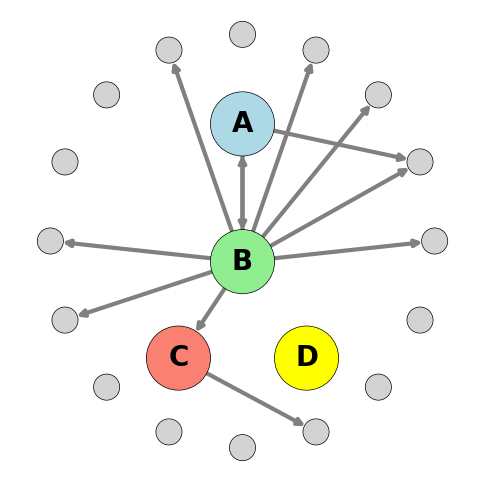

In [193]:
off_diag_idx = get_off_diag_idx(20)
g = create_graph(state_2_matrix[1:,1:].reshape(20**2)[off_diag_idx], 20)


node_center =["A", "B", "C", "D"]

for i, node in enumerate(node_center[:2]):
    pos[node] = (0, -i-0.65)
pos["C"] = (-0.5, -2-0.35)
pos["D"] = (0.5, -2-0.35)

# Arrange orbit nodes in a circular layout around the main ones
angle_step = 2 * np.pi / 16
radius = 1.5
for i, node in enumerate(range(5,21)):
    angle = i * angle_step
    pos[node] = (radius * np.cos(angle), -1.5 + radius * np.sin(angle))  # Centered around (0, -2)

node_sizes = {node: 2000 for node in node_center}  # Larger main nodes
node_sizes.update({node: 300 for node in range(5,21)})  # Smaller orbit nodes

node_colors = {"A": 'lightblue',
               "B": 'lightgreen',
               "C": 'salmon',
               "D": 'yellow'}  # Larger main nodes
node_colors.update({node: 'lightgray' for node in range(5,21)})  # Smaller orbit nodes

fontsizes = {node: 20 for node in node_center}  # Larger main nodes
fontsizes.update({node: 10 for node in range(5,21)})  # Smaller orbit nodes

plt.figure(figsize=(6, 6))

nx.draw_networkx_nodes(g, pos, node_size=[node_sizes[n] for n in g.nodes()], 
                       node_color='lightblue', edgecolors='black', linewidths=2)


nx.draw(g, pos, with_labels=False, node_size=[node_sizes[n] for n in g.nodes()], 
        node_color=[node_colors[n] for n in g.nodes()], edge_color='gray', connectionstyle="arc3,rad=0.", width=3)

# Draw labels **ONLY for main nodes**
for node in node_center:
    x, y = pos[node]
    plt.text(x, y, node, fontsize=20, fontweight='bold', ha='center', va='center')

plt.savefig("graph_state_2.pdf",bbox_inches='tight')
plt.show()